# ANÁLISIS PRELIMINAR DE LOS ARCHIVOS DE DATOS

In [18]:
# Para visualizar los gráficos en el notebook escribimos:

%matplotlib inline  

# A continuación, importamos las librerías necesarias:

import healpy as hp # Indispensable para trabajar con mapas de HEALPix
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io import fits # Indispensable para leer los archivos FITS

# Definimos como variable el nombre del archivo FITS que contiene el mapa para proceder a su lectura:

map11='quijote_mfi_smth_skymap_11ghz_512_dr1.fits'

hdul = fits.open(map11) # HDU (Header Data Unit) es la unidad básica de información en un archivo FITS.
hdul.info()

Filename: quijote_mfi_smth_skymap_11ghz_512_dr1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     50   3072R x 5C   [1024E, 1024E, 1024E, 1024E, 1024E]   


In [19]:
hdul[0].header # Encabezado principal del archivo FITS. No contiene datos (NAXIS=0), solo información sobre el archivo.

SIMPLE  =                    T / Written by IDL:  Thu Dec 15 10:03:08 2022      
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2022-12-15'         / Creation date (CCYY-MM-DD) of FITS header      
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    

In [20]:
hdul[1].header # Encabezado secundario. Se trata de una tabla binaria que contiene todos los datos del mapa.
# Contiene 5 columnas correspondientes a los parámetros de Stokes y sus números de hits.

XTENSION= 'BINTABLE'           /Written by IDL:  Thu Dec 15 10:03:08 2022       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                20480 /Number of bytes per row                         
NAXIS2  =                 3072 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    5 /Number of columns                               
TFORM1  = '1024E   '           /Real*4 (floating point)                         
TTYPE1  = 'I_STOKES'           /                                                
TUNIT1  = 'mK_CMB  '           /physical unit of field                          
TFORM2  = '1024E   '           /Real*4 (floating point)                         
TTYPE2  = 'Q_STOKES'        

In [21]:
hdul.close()

##### ¿Qué son los parámetros?

1. **Intensidad total Stokes (I)**: representa la intensidad total de la radiación, es decir, la suma de la energía transportada por todas las componentes de la onda (polarizada o no). 
$$
I=|E_x|^2+|E_y|^2
$$

2. **Polarización lineal horizontal o vertical (Q)**: mide la diferencia en la intensidad de la radiación polarizada en dos direcciones ortogonales (vertical y horizontal).
$$
Q=|E_x|^2-|E_y|^2
$$

3. **Polarización lineal en $\pm 45^o$ (U)**: mide la diferencia de intensidad en un par de ejes rotados 45 grados respecto a los anteriores.
$$
U= 2Re(E_xE_y^*)
$$
Estos dos últimos parámetros nos permiten determinar el ángulo de la polarización lineal $(\psi)$ y el grado de polarización (P), mediante las relaciones:
$$
P=\frac{\sqrt{Q^2+U^2}}{I} , \quad \psi=\frac{1}{2}\arctan(\frac{U}{Q})
$$
*Los tres parámetros mencionados se miden en milikelvin (mK).*

4. **Número de hits de I**

5. **Número de hits de Q,U**

Los "hits" son el número de veces que cada píxel ha sido medido durante el experimento. Un valor alto de "hits" permite obtener una estimación más precisa y con menor ruido.

In [22]:
map11ghz = hp.read_map(map11, field=(0,1,2,3,4)) # Cargamos un array con las cinco columnas

In [23]:
# A continuación, mostramos el número de píxeles totales en el mapa y 
# el número de píxeles observados por QUIJOTE, dejando de lado los píxeles no válidos.

print("Total de píxeles en el mapa:", map11ghz.size)
print("Píxeles observados:", np.sum(map11ghz != hp.UNSEEN))


Total de píxeles en el mapa: 15728640
Píxeles observados: 9320085


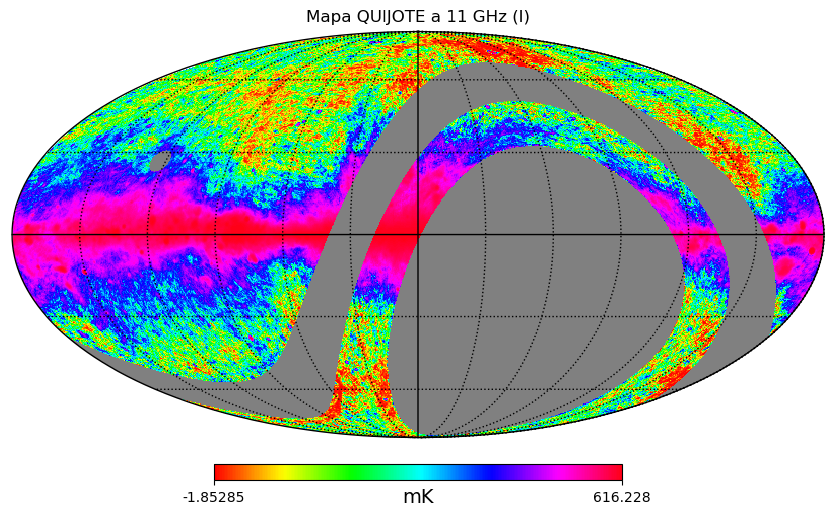

In [24]:
#A continuación vamos a visualizar el mapa de la intensidad total de la radiación observada en cada píxel. 
# Para cada píxel del mapa se almacena el valor de temperatura correspondiente, 
# se incluye tanto la señal cósmica (CMB) como las emisiones de los fondos galácticos.

hp.mollview(map11ghz[0,:], 
            title="Mapa QUIJOTE a 11 GHz (I)", 
            unit="mK",
            cmap="hsv",
            norm="hist")
hp.graticule()
plt.show()

##### ¿Por qué el mapa está "incompleto"?
Esas "manchas grises" que se observan se deben a los datos inválidos o inexistentes. 
- La banda central se debe a las interferencias o saturación de los satélites que orbitan la Tierra.
- El área inferior corresponde al hemisferio sur, el cual, por la localización de los telescopios (Islas Canarias), queda fuera del campo de visión.
- El círculo se debe a la imposibilidad de medición en la vertical del telescopio (no existe barrido).

In [25]:
np.ma.is_masked(map11ghz) 
# Los masked arrays son estructuras que permiten manejar datos faltantes o 
# inválidos mediante una máscara booleana que indica qué elementos están "enmascarados" o 
# ignorados en los cálculos.

False

In [26]:
print("NaNs:", np.isnan(map11ghz).any())
# Verificamos si hay valores NaN en el mapa

NaNs: False


In [27]:
print("Infs:", np.isinf(map11ghz).any())
# Verificamos si hay valores infinitos en el mapa

Infs: False


In [28]:
unseen_mask11 = (map11ghz == hp.UNSEEN)
print("Número de píxeles con hp.UNSEEN:", unseen_mask11.sum())

# El código crea una máscara booleana llamada 'unseen_mask' que es True para cada píxel 
# en 'map11ghz' cuyo valor es igual a 'hp.UNSEEN' (un valor que Healpy utiliza para 
# marcar píxeles sin datos o no válidos). 
# Luego, al sumar esta máscara con '.sum()', se cuenta el número total de píxeles 
# que tienen ese valor especial. Es una forma de detectar cuántos píxeles están marcados 
# como "no vistos" o sin información.

Número de píxeles con hp.UNSEEN: 6408555


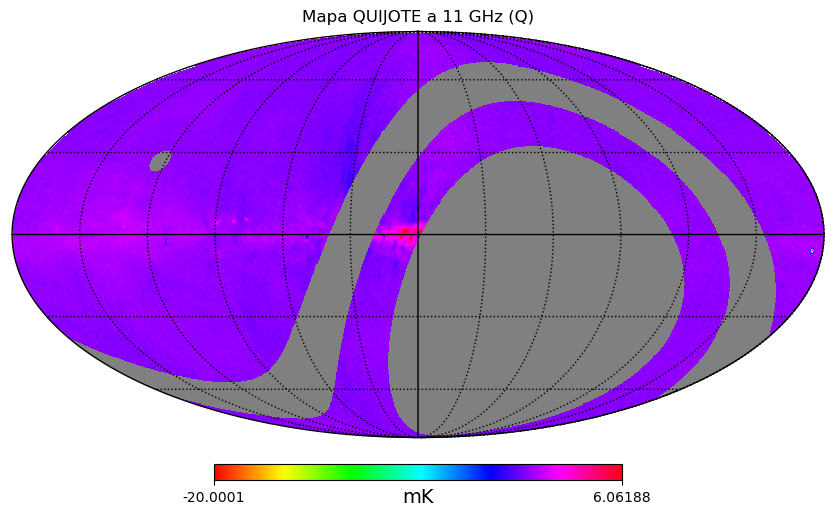

In [29]:
# A continuación, graficamos los mapas de polarización. 
# Estos son los que nos interesan realmente y con los que trabajaremos de aquí en adelante.

hp.mollview(map11ghz[1,:], 
            cmap='hsv', 
            title="Mapa QUIJOTE a 11 GHz (Q)", 
            unit="mK")
hp.graticule()
plt.show()

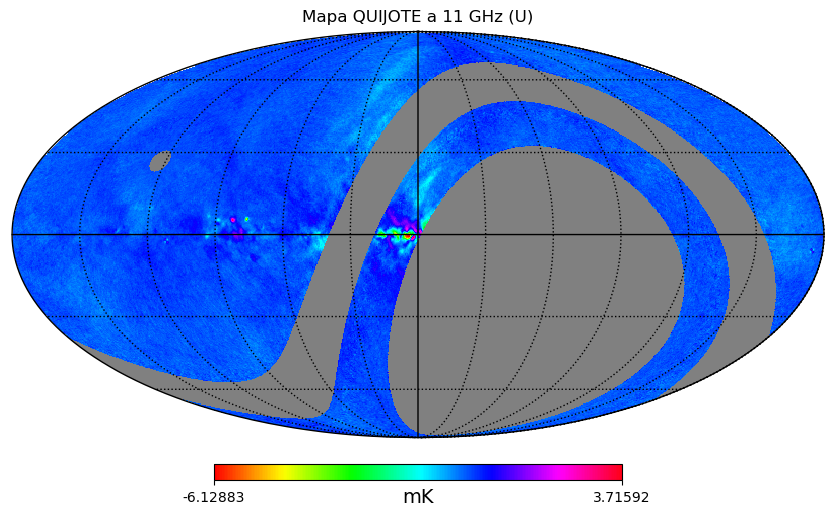

In [30]:
hp.mollview(map11ghz[2,:],
            cmap='hsv', 
            title="Mapa QUIJOTE a 11 GHz (U)", 
            unit="mK")
hp.graticule()
plt.show()

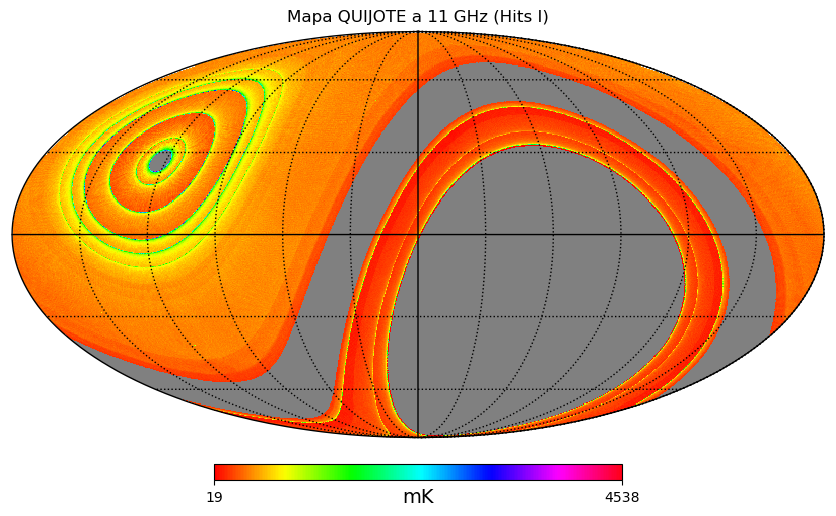

In [31]:
# Finalmente, graficamos el número de hits (número de observaciones) por píxel.
# Estos nos serán útiles en la propagación de errores y en la creación de mapas de incertidumbre.

hp.mollview(map11ghz[3,:], 
            cmap='hsv',
            title="Mapa QUIJOTE a 11 GHz (Hits I)", 
            unit="mK")
hp.graticule()
plt.show()

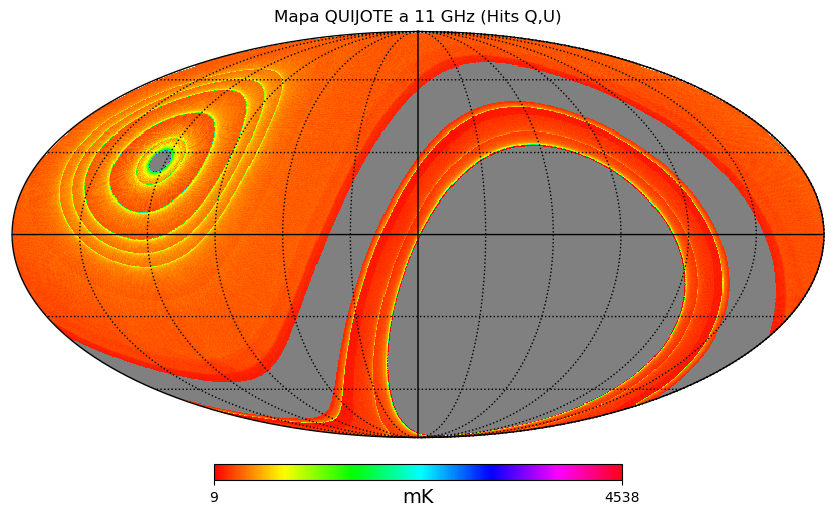

In [32]:
hp.mollview(map11ghz[4,:], 
            cmap='hsv',
            title="Mapa QUIJOTE a 11 GHz (Hits Q,U)", 
            unit="mK")
hp.graticule()
plt.show()

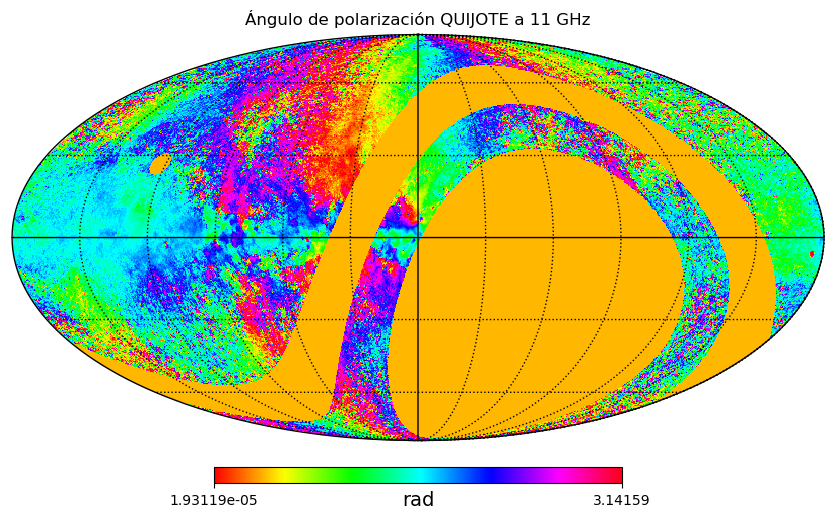

In [33]:
######### PRUEBA DE OBTENCIÓN DEL DIFERENCIAL DE ÁNGULO PSI #########
# Por convenio, queremos que los límites sean [0,pi]. Por ende, se deben sumar pi/2.

difpsi= 0.5*np.arctan2(map11ghz[2,:], map11ghz[1,:]) + np.pi/2

hp.mollview(difpsi,
            cmap='hsv',
            title="Ángulo de polarización QUIJOTE a 11 GHz", 
            unit="rad")
hp.graticule()
plt.show()

## ESTUDIO ANÁLOGO DEL RESTO DE FRECUENCIAS

Total de píxeles en el mapa de 11 GHz: 15728640
Píxeles observados en el mapa de 11 GHz: 9320085
Número de píxeles con hp.UNSEEN en el mapa de 11 GHz: 6408555


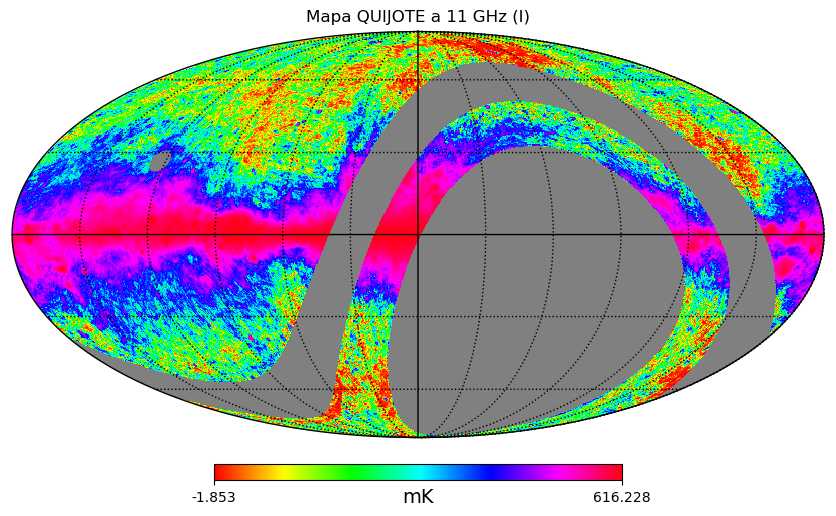

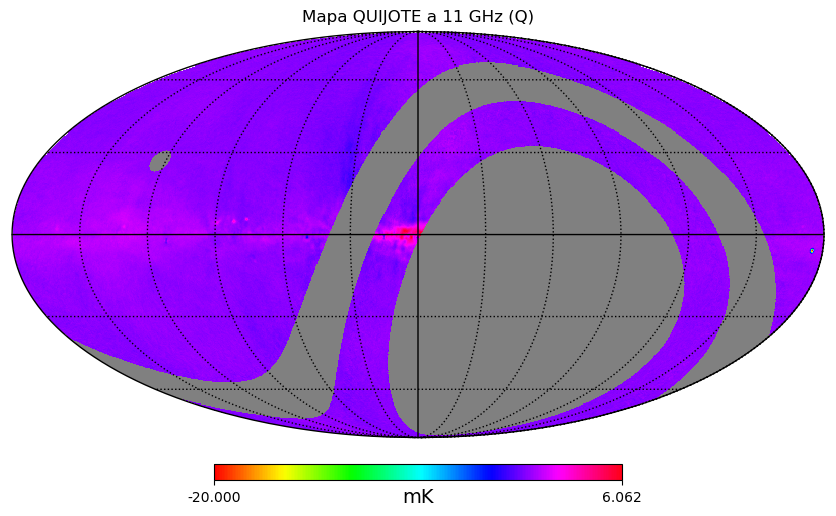

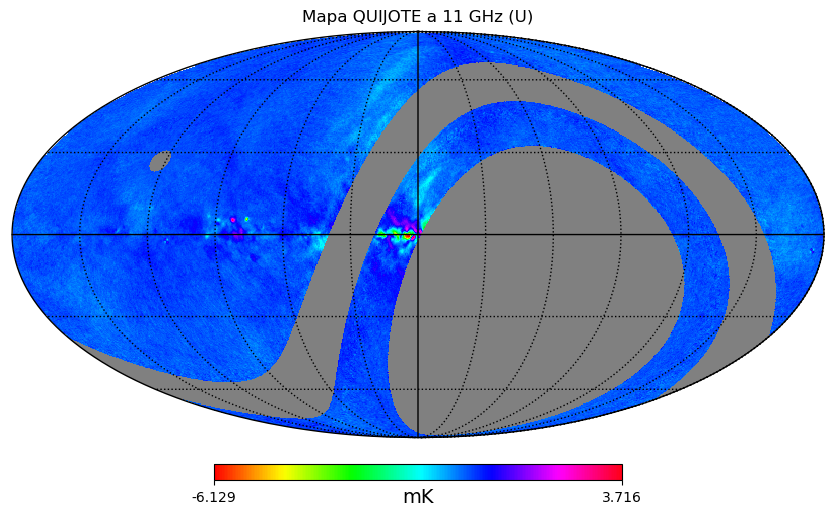

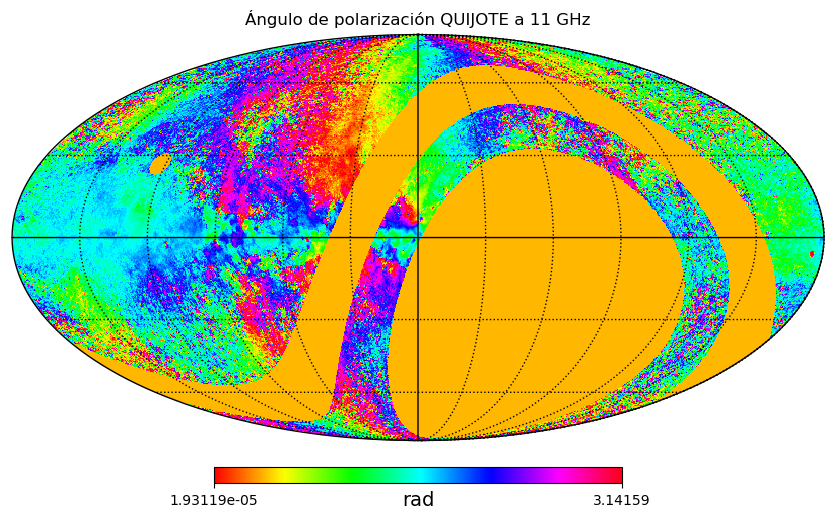

Total de píxeles en el mapa de 13 GHz: 15728640
Píxeles observados en el mapa de 13 GHz: 9319170
Número de píxeles con hp.UNSEEN en el mapa de 13 GHz: 6409470


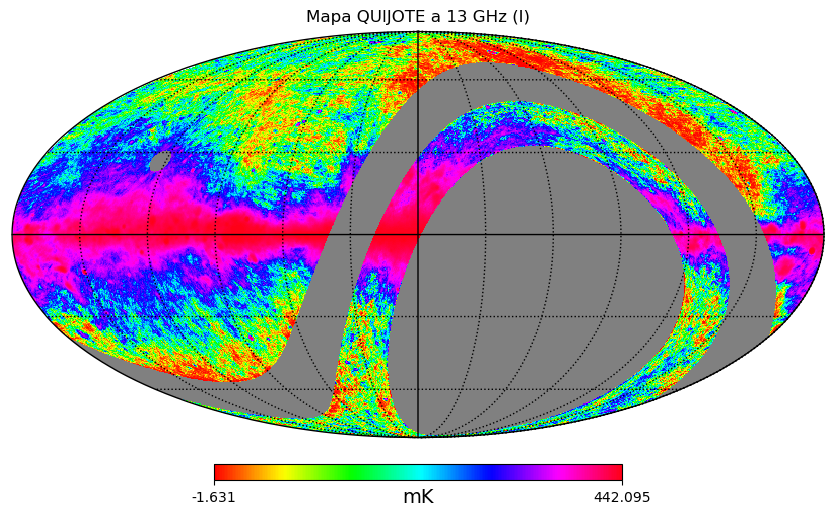

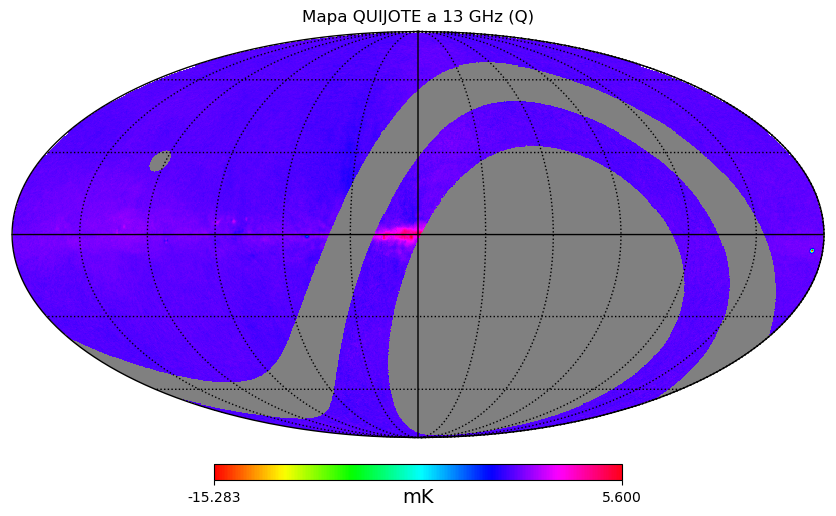

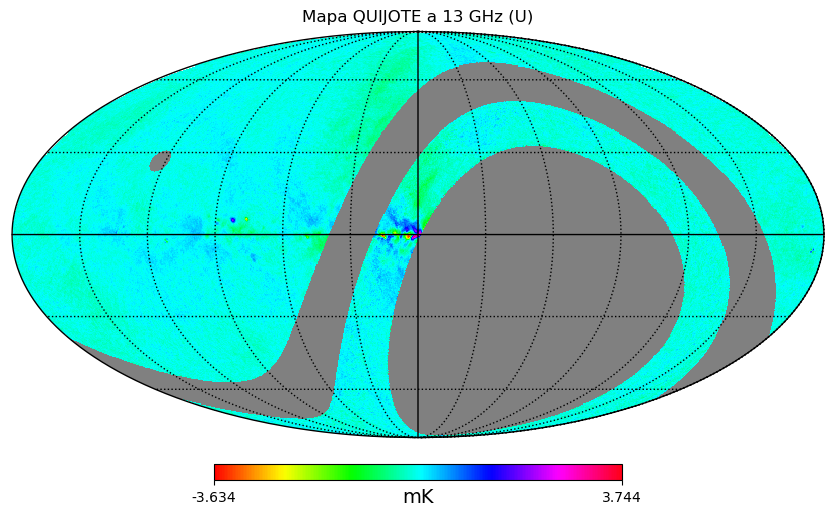

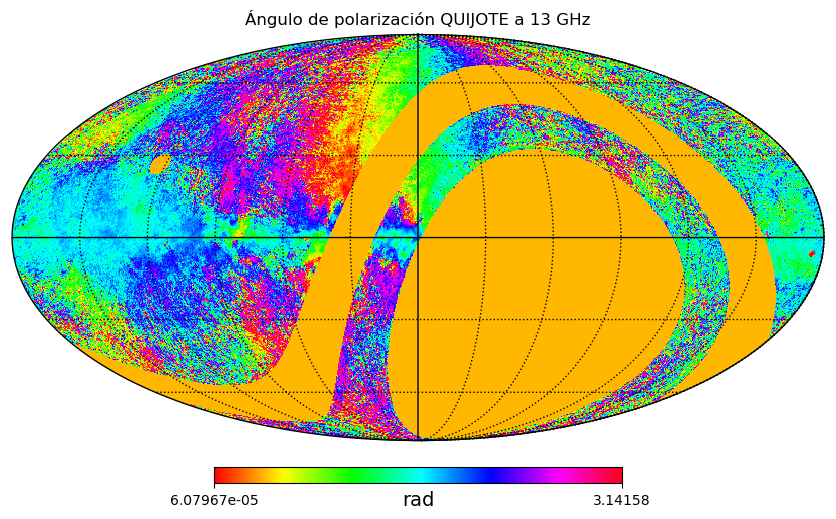

Total de píxeles en el mapa de 17 GHz: 15728640
Píxeles observados en el mapa de 17 GHz: 9320325
Número de píxeles con hp.UNSEEN en el mapa de 17 GHz: 6408315


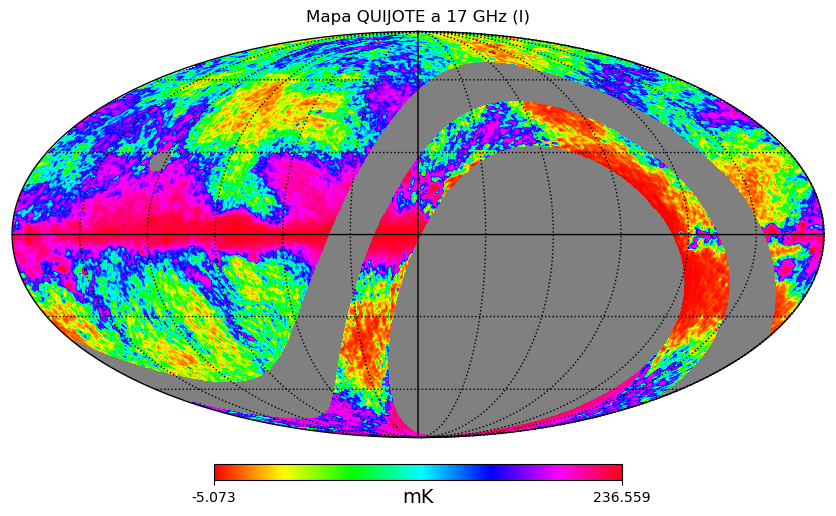

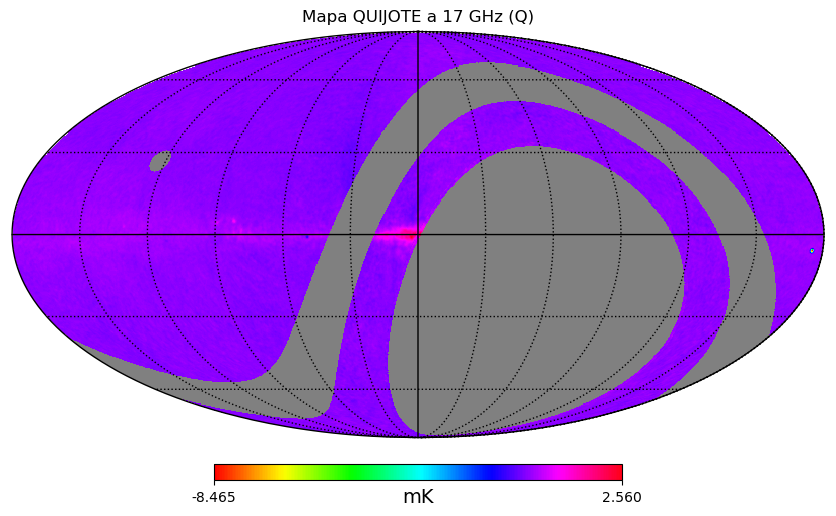

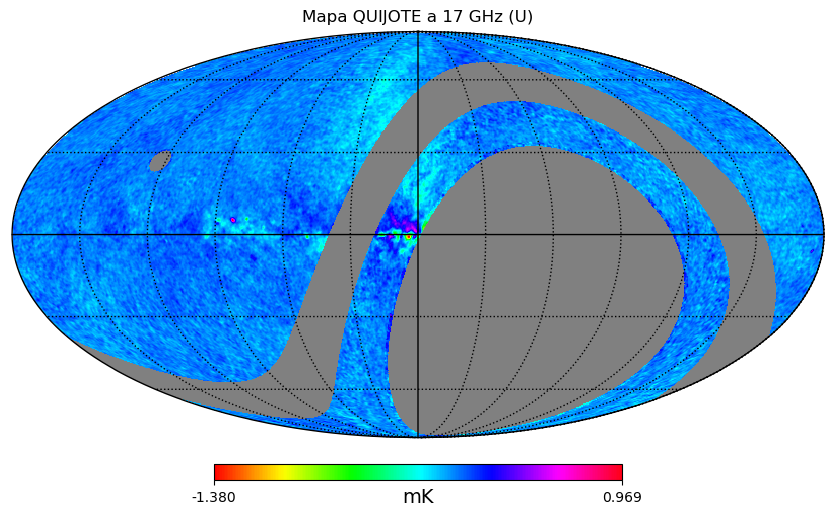

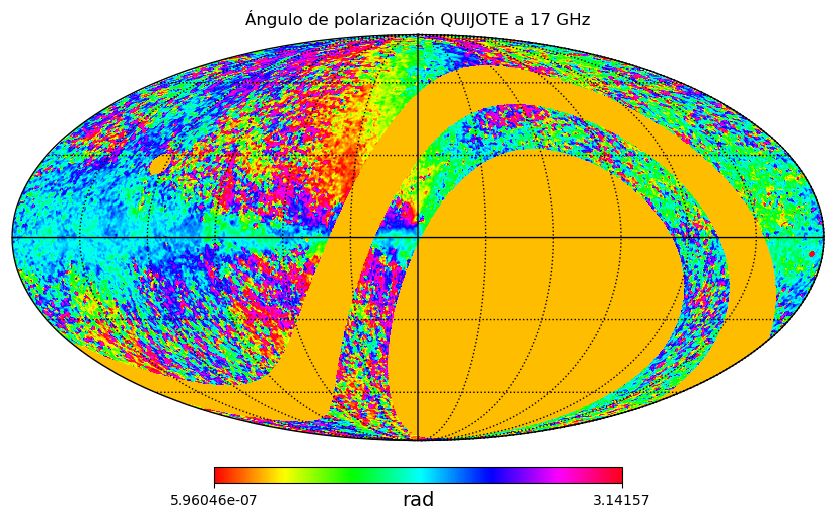

Total de píxeles en el mapa de 19 GHz: 15728640
Píxeles observados en el mapa de 19 GHz: 9320166
Número de píxeles con hp.UNSEEN en el mapa de 19 GHz: 6408474


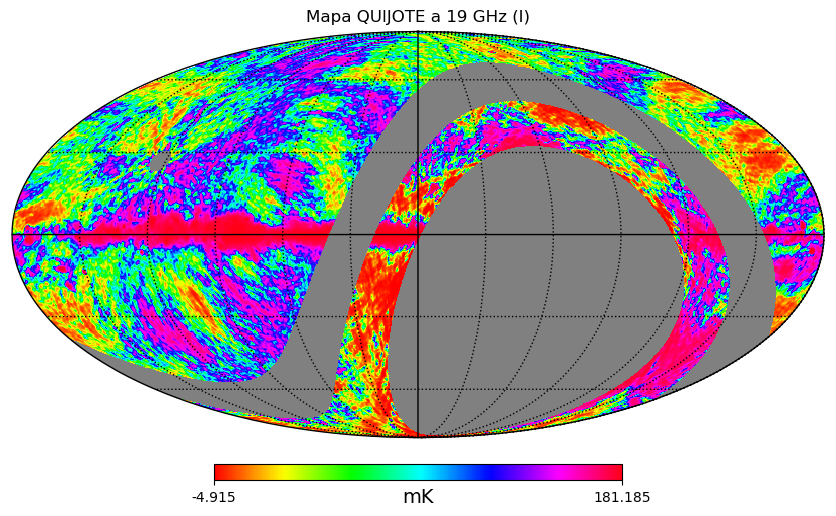

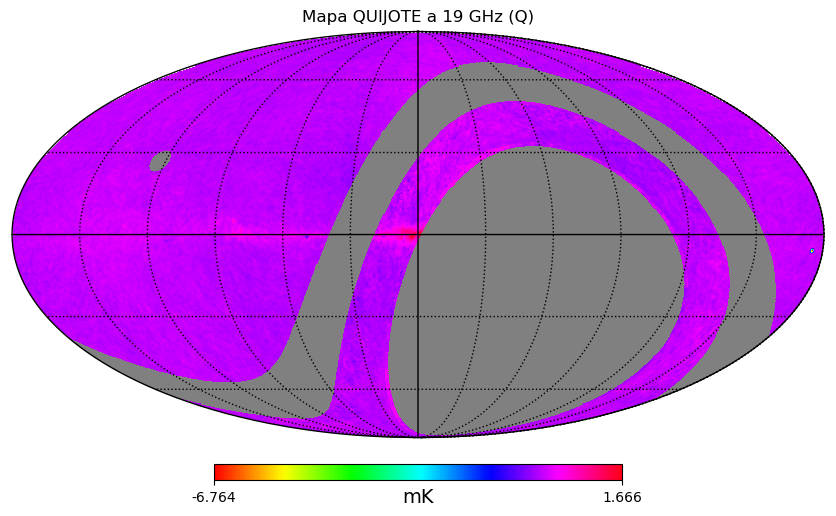

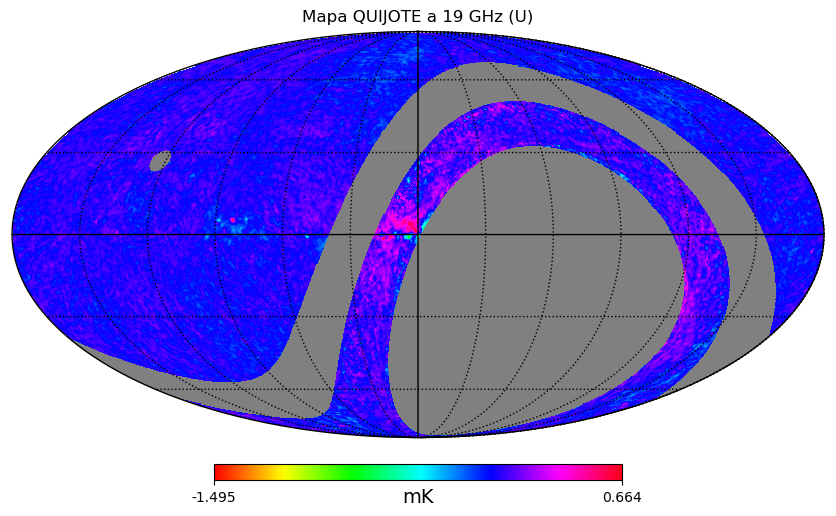

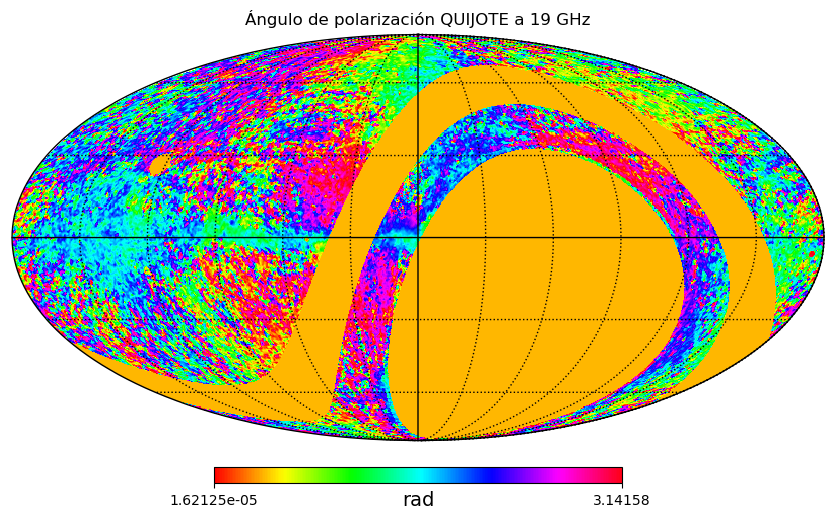

In [34]:
frecuencias=[11, 13, 17, 19]

for freq in frecuencias:
    map_file = f'quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits'
    map_data = hp.read_map(map_file, field=(0,1,2,3,4))

    print(f"Total de píxeles en el mapa de {freq} GHz:", map_data.size)
    print(f"Píxeles observados en el mapa de {freq} GHz:", np.sum(map_data != hp.UNSEEN))
    unseen_mask = (map_data == hp.UNSEEN)
    print(f"Número de píxeles con hp.UNSEEN en el mapa de {freq} GHz:", unseen_mask.sum())
    
    hp.mollview(map_data[0,:], 
                title=f"Mapa QUIJOTE a {freq} GHz (I)", 
                format="%.3f",
                unit="mK",
                cmap="hsv",
                norm="hist")
    hp.graticule()
    plt.show()

    hp.mollview(map_data[1,:], 
                cmap='hsv', 
                title=f"Mapa QUIJOTE a {freq} GHz (Q)", 
                format="%.3f",
                unit="mK")
    hp.graticule()
    plt.show()

    hp.mollview(map_data[2,:], 
                cmap='hsv',
                title=f"Mapa QUIJOTE a {freq} GHz (U)", 
                format="%.3f",
                unit="mK")
    hp.graticule()
    plt.show()

    difpsi= 0.5*np.arctan2(map_data[2,:], map_data[1,:]) + np.pi/2
    hp.mollview(difpsi,
                cmap='hsv',
                title=f"Ángulo de polarización QUIJOTE a {freq} GHz", 
                unit="rad")
    hp.graticule()
    plt.show()